In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()

# Set up Kaggle directory and API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

# Download and unzip Handwriting BCI dataset
!kaggle datasets download -d saurabhshahane/handwriting-bci
!unzip handwriting-bci.zip

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

from sklearn.preprocessing import LabelEncoder

import string

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import argparse
import os
from pathlib import Path
import time
import sys
import random
from collections import Counter

from dateutil.parser import parse as dtparse
import numpy as np
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from google.colab import drive
from datetime import datetime

MATPLOTLIB_COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]



In [ ]:

########################################################################################
# Main function.
########################################################################################
ALL_CHARS = [
    *string.ascii_lowercase,
    "greaterThan",
    "tilde",
    "questionMark",
    "apostrophe",
    "comma",
]
CHAR_REPLACEMENTS = {
    "greaterThan": ">",
    "tilde": "~",
    "questionMark": "?",
    "apostrophe": "'",
    "comma": ",",
}
CHAR_TO_CLASS_MAP = {char: idx for idx, char in enumerate(ALL_CHARS)}
CLASS_TO_CHAR_MAP = {idx: char for idx, char in enumerate(ALL_CHARS)}

# hyperparams
NUM_ELECTRODES=192 # electrode input
SEQUENCE_LENGTH=150 # time bins
NUM_LAYERS=2
HIDDEN_SIZE=512
NUM_CLASSES=len(ALL_CHARS)
LEARNING_RATE=0.0005
BATCH_SIZE=64
NUM_EPOCHS=5

RNN_COLOR="#ff00ff"
KNN_COLOR="#f90"
LR_COLOR="#6aa84f"

def main():

    show_plots = True

    """
    COMPARING DIFFERNT MODELS (Figure 3)
    """

    ## Load the data.

    data_dicts = load_data()

    # Mount Google Drive
    drive.mount('/content/gdrive')
    run_ts = datetime.now().strftime("%Y%m%d%H%M%S")

    # Run RNN
    rnn_accuracies = run_multiple_RNN(data_dicts)
    file_path = f'/content/gdrive/MyDrive/ECS289G_Project_Results/rnn_accuracies_{run_ts}.txt'
    np.savetxt(file_path, rnn_accuracies, fmt='%.3f')

    # Run KNN
    knn_accuracies = run_multiple_KNN(data_dicts)
    file_path = f'/content/gdrive/MyDrive/ECS289G_Project_Results/knn_accuracies_{run_ts}.txt'
    np.savetxt(file_path, knn_accuracies, fmt='%.3f')

    # Run Logistic Regression
    lr_accuracies = run_multiple_LR(data_dicts)
    file_path = f'/content/gdrive/MyDrive/ECS289G_Project_Results/lr_accuracies_{run_ts}.txt'
    np.savetxt(file_path, lr_accuracies, fmt='%.3f')


    plot_test_accuracies(rnn_accuracies, knn_accuracies, lr_accuracies)

    NUM_ELECTRODES_TO_TRY = [48, 96, 144, 192]
    rnn_electrode_accuracies = []
    knn_electrode_accuracies = []
    lr_electrode_accuracies = []
    for num_electrodes in NUM_ELECTRODES_TO_TRY:
      rnn_electrode_accuracy = run_multiple_RNN(data_dicts, num_electrodes=num_electrodes, num_runs=1)
      rnn_electrode_accuracies.append(rnn_electrode_accuracy)

      knn_electrode_accuracy = run_multiple_KNN(data_dicts, num_electrodes=num_electrodes, num_runs=1)
      knn_electrode_accuracies.append(knn_electrode_accuracy)

      lr_electrode_accuracy = run_multiple_LR(data_dicts, num_electrodes=num_electrodes, num_runs=1)
      lr_electrode_accuracies.append(lr_electrode_accuracy)

    file_path = f'/content/gdrive/MyDrive/ECS289G_Project_Results/rnn_electrode_accuracies_{run_ts}.txt'
    np.savetxt(file_path, rnn_electrode_accuracies, fmt='%.3f')
    file_path = f'/content/gdrive/MyDrive/ECS289G_Project_Results/knn_electrode_accuracies_{run_ts}.txt'
    np.savetxt(file_path, knn_electrode_accuracies, fmt='%.3f')
    file_path = f'/content/gdrive/MyDrive/ECS289G_Project_Results/lr_electrode_accuracies_{run_ts}.txt'
    np.savetxt(file_path, lr_electrode_accuracies, fmt='%.3f')

    # Plotting the lines
    plt.plot(NUM_ELECTRODES_TO_TRY, rnn_electrode_accuracies, marker='o', linestyle='-', color='b', label='RNN')
    plt.plot(NUM_ELECTRODES_TO_TRY, knn_electrode_accuracies, marker='s', linestyle='-', color='r', label='KNN')
    plt.plot(NUM_ELECTRODES_TO_TRY, lr_electrode_accuracies, marker='^', linestyle='-', color='g', label='Logistic Regression')

    # Adding labels and title
    plt.xlabel('Number of Electrodes')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Electrodes')
    plt.legend()

    # Show the plot
    plt.show()


    NUM_TRAIN_TRIALS_TO_TRY = [300, 600, 900, 1200, 1500, 1800, 2100]
    rnn_train_trial_accuracies = []
    knn_train_trial_accuracies = []
    lr_train_trial_accuracies = []
    for num_train_trials in NUM_TRAIN_TRIALS_TO_TRY:
      rnn_train_trial_accuracy = run_multiple_RNN(data_dicts, num_train_trials=num_train_trials, num_runs=1)
      rnn_train_trial_accuracies.append(rnn_train_trial_accuracy)

      knn_train_trial_accuracy = run_multiple_KNN(data_dicts, num_train_trials=num_train_trials, num_runs=1)
      knn_train_trial_accuracies.append(knn_train_trial_accuracy)

      lr_train_trial_accuracy = run_multiple_LR(data_dicts, num_train_trials=num_train_trials, num_runs=1)
      lr_train_trial_accuracies.append(lr_train_trial_accuracy)

    file_path = f'/content/gdrive/MyDrive/ECS289G_Project_Results/rnn_train_trial_accuracies_{run_ts}.txt'
    np.savetxt(file_path, rnn_train_trial_accuracies, fmt='%.3f')
    file_path = f'/content/gdrive/MyDrive/ECS289G_Project_Results/knn_train_trial_accuracies_{run_ts}.txt'
    np.savetxt(file_path, knn_train_trial_accuracies, fmt='%.3f')
    file_path = f'/content/gdrive/MyDrive/ECS289G_Project_Results/lr_train_trial_accuracies_{run_ts}.txt'
    np.savetxt(file_path, lr_train_trial_accuracies, fmt='%.3f')

    # Plotting the lines
    plt.plot(NUM_TRAIN_TRIALS_TO_TRY, rnn_train_trial_accuracies, marker='o', linestyle='-', color='b', label='RNN')
    plt.plot(NUM_TRAIN_TRIALS_TO_TRY, knn_train_trial_accuracies, marker='s', linestyle='-', color='r', label='KNN')
    plt.plot(NUM_TRAIN_TRIALS_TO_TRY, lr_train_trial_accuracies, marker='^', linestyle='-', color='g', label='Logistic Regression')

    # Adding labels and title
    plt.xlabel('Number of Training Trials')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Training Size')
    plt.legend()

    # Show the plot
    plt.show()


    """
    TESTING DIFFERENT TRIALS (Figure 4)
    """


def plot_train_trials_accuracies(num_train_trials_list, rnn_train_trial_accuracies, knn_train_trial_accuracies, lr_train_trial_accuracies):
    # Plotting the lines
    plt.plot(num_train_trials_list, rnn_train_trial_accuracies, marker='o', linestyle='-', color=RNN_COLOR, label='RNN')
    plt.plot(num_train_trials_list, knn_train_trial_accuracies, marker='s', linestyle='-', color=KNN_COLOR, label='KNN')
    plt.plot(num_train_trials_list, lr_train_trial_accuracies, marker='^', linestyle='-', color=LR_COLOR, label='Logistic Regression')

    # Adding labels and title
    plt.xlabel('Number of Training Trials')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Training Size')
    plt.legend()
    plt.show()

def plot_electrode_accuracies(num_electrodes_list, rnn_electrode_accuracies, knn_electrode_accuracies, lr_electrode_accuracies):
    # Plotting the lines
    plt.plot(num_electrodes_list, rnn_electrode_accuracies, marker='o', linestyle='-', color=RNN_COLOR, label='RNN')
    plt.plot(num_electrodes_list, knn_electrode_accuracies, marker='s', linestyle='-', color=KNN_COLOR, label='KNN')
    plt.plot(num_electrodes_list, lr_electrode_accuracies, marker='^', linestyle='-', color=LR_COLOR, label='Logistic Regression')

    # Adding labels and title
    plt.xlabel('Number of Electrodes')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Electrodes')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()


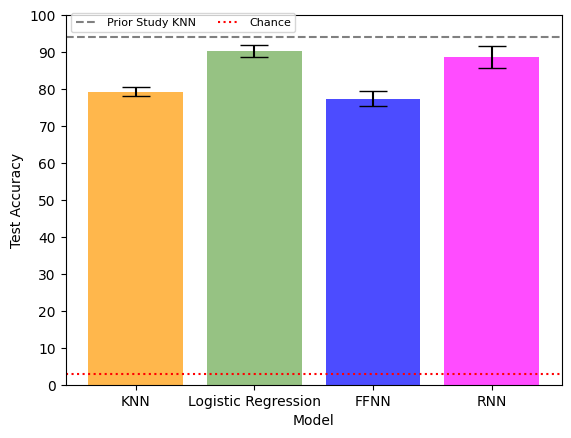

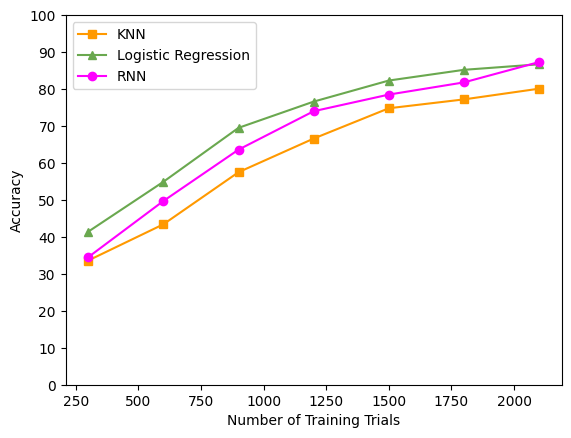

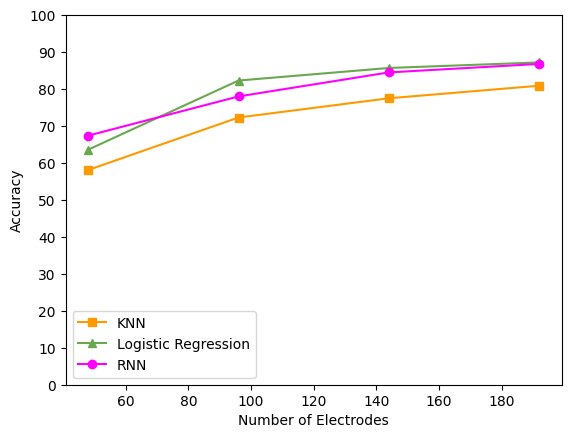

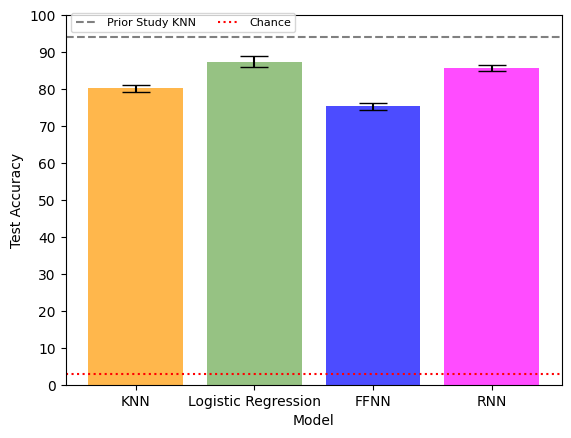

In [24]:
import numpy as np
RNN_COLOR="#ff00ff"
KNN_COLOR="#f90"
LR_COLOR="#6aa84f"
FFNN_COLOR="#0000ff"

def plot_train_trials_accuracies(num_train_trials_list, rnn_train_trial_accuracies, knn_train_trial_accuracies, lr_train_trial_accuracies):
    # Plotting the lines
    plt.plot(num_train_trials_list, np.array(knn_train_trial_accuracies) * 100, marker='s', linestyle='-', color=KNN_COLOR, label='KNN')
    plt.plot(num_train_trials_list, np.array(lr_train_trial_accuracies) * 100, marker='^', linestyle='-', color=LR_COLOR, label='Logistic Regression')
    plt.plot(num_train_trials_list, np.array(rnn_train_trial_accuracies) * 100, marker='o', linestyle='-', color=RNN_COLOR, label='RNN')

    # Adding labels and title
    plt.xlabel('Number of Training Trials')
    plt.ylabel('Accuracy')
    plt.legend()

    # Set y-axis ticks to increment in 10s
    plt.yticks(range(0, 101, 10))

    plt.show()

def plot_electrode_accuracies(num_electrodes_list, rnn_electrode_accuracies, knn_electrode_accuracies, lr_electrode_accuracies):
    # Plotting the lines
    plt.plot(num_electrodes_list, np.array(knn_electrode_accuracies) * 100, marker='s', linestyle='-', color=KNN_COLOR, label='KNN')
    plt.plot(num_electrodes_list, np.array(lr_electrode_accuracies) * 100, marker='^', linestyle='-', color=LR_COLOR, label='Logistic Regression')
    plt.plot(num_electrodes_list, np.array(rnn_electrode_accuracies) * 100, marker='o', linestyle='-', color=RNN_COLOR, label='RNN')

    # Adding labels and title
    plt.xlabel('Number of Electrodes')
    plt.ylabel('Accuracy')
    plt.legend()

    # Set y-axis ticks to increment in 10s
    plt.yticks(range(0, 101, 10))

    plt.show()

def plot_test_accuracies(rnn_accuracies, knn_accuracies, logistic_accuracies, ffnn_accuracies):
    # Calculate mean and standard deviation for error bars
    rnn_mean, rnn_std = np.mean(np.array(rnn_accuracies) * 100), np.std(np.array(rnn_accuracies) * 100)
    knn_mean, knn_std = np.mean(np.array(knn_accuracies) * 100), np.std(np.array(knn_accuracies) * 100)
    logistic_mean, logistic_std = np.mean(np.array(logistic_accuracies) * 100), np.std(np.array(logistic_accuracies) * 100)
    ffnn_mean, ffnn_std = np.mean(np.array(ffnn_accuracies) * 100), np.std(np.array(ffnn_accuracies) * 100)

    # Data for plotting
    labels = ['KNN', 'Logistic Regression', 'FFNN', 'RNN']  # FFNN before RNN
    means = [knn_mean, logistic_mean, ffnn_mean, rnn_mean]
    stds = [knn_std, logistic_std, ffnn_std, rnn_std]

    # Colors
    colors = [KNN_COLOR, LR_COLOR, FFNN_COLOR, RNN_COLOR]  # Adding color for FFNN

    # Plotting
    fig, ax = plt.subplots()
    ax.bar(labels, means, yerr=stds, align='center', alpha=0.7, ecolor='black', capsize=10, color=colors)
    ax.set_ylabel('Test Accuracy')
    ax.set_xlabel('Model')

    # Set y-axis ticks to increment in 10s
    plt.yticks(range(0, 101, 10))

    # Add a dashed line at 94%
    ax.axhline(y=94, color='grey', linestyle='--', label='Prior Study KNN')

    # Add a dotted line at chance (you can adjust the y value accordingly)
    ax.axhline(y=3, color='red', linestyle=':', label='Chance')

    # Add legend
    ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.02), ncol=2, prop={'size': 8})

    # Show the plot
    plt.show()


def plot_recorded_accuracies():
  # values for training trials
  num_train_trials_list = [300, 600, 900, 1200, 1500, 1800, 2100]
  rnn_train_trial_accuracies = [0.345, 0.497, 0.636, 0.740, 0.785, 0.818, 0.873]
  knn_train_trial_accuracies = [0.336, 0.434, 0.575, 0.666, 0.748, 0.772, 0.801]
  lr_train_trial_accuracies = [0.414, 0.549, 0.695, 0.766, 0.823, 0.852, 0.867]

  # values for electrodes
  num_electrodes_list = [48, 96, 144, 192]
  rnn_electrode_accuracies = [0.674, 0.780, 0.845, 0.868]
  knn_electrode_accuracies = [0.581, 0.723, 0.775, 0.809]
  lr_electrode_accuracies = [0.636, 0.823, 0.857, 0.872]

  # values for test accuracies
  rnn_test_accuracies = [0.845, 0.847, 0.865, 0.861, 0.867]
  knn_test_accuracies = [0.803, 0.789, 0.813, 0.808, 0.796]
  logistic_test_accuracies = [0.863, 0.861, 0.901, 0.864, 0.880]
  ffnn_accuracies = [0.743, 0.760, 0.743, 0.754, 0.764]

  # Call each plotting function
  plot_train_trials_accuracies(num_train_trials_list, rnn_train_trial_accuracies, knn_train_trial_accuracies, lr_train_trial_accuracies)
  plot_electrode_accuracies(num_electrodes_list, rnn_electrode_accuracies, knn_electrode_accuracies, lr_electrode_accuracies)
  plot_test_accuracies(rnn_test_accuracies, knn_test_accuracies, logistic_test_accuracies, ffnn_accuracies)

In [ ]:

########################################################################################
# Helper functions.
########################################################################################


def load_data():
    """
    Scrape the data directory and load the data files from disk into dicts in memory.
    """
    # Specify the path to the dataset directory
    DATA_DIR = os.path.abspath("/content/handwritingBCIData/Datasets/")
    letters_filepaths = []

    # Iterate through the files in the dataset directory
    for root, _, filenames in os.walk(DATA_DIR):
        for filename in filenames:
            filepath = os.path.join(root, filename)
            if filename == "singleLetters.mat":
                letters_filepaths.append(filepath)

    letters_filepaths = sorted(letters_filepaths)

    data_dicts = []
    for filepath in letters_filepaths:
        print(f"Loading {filepath} ...")
        data_dict = loadmat(filepath)
        data_dicts.append(data_dict)
        # break  # for testing quickly

    return data_dicts


def visualize_neural_data(data_dicts):
    """"""

    print("Visualizing the neural data ...")

    num_plots = len(data_dicts)
    num_cols = int(np.ceil(np.sqrt(num_plots)))
    num_rows = int(np.ceil(num_plots / num_cols))

    fig, axs = plt.subplots(num_rows, num_cols)

    if type(axs) != np.ndarray:
        axs = np.array([[axs]])

    for session_idx, data_dict in enumerate(data_dicts):
        session_date = dtparse(data_dict["blockStartDates"][0][0][0]).date()

        timestamps = data_dict["clockTimeSeries"]
        bin_lengths = np.diff(timestamps.flatten())
        real_bin_lengths = bin_lengths[bin_lengths > 0]
        bin_length_sec = np.round(np.mean(real_bin_lengths), 4)

        neural_activity = data_dict["neuralActivityTimeSeries"]
        delay_cue_bins = data_dict["delayPeriodOnsetTimeBin"]
        go_cue_bins = data_dict["goPeriodOnsetTimeBin"]
        prompts = data_dict["characterCues"]

        NUM_PCS = 3
        pca_model = PCA(n_components=NUM_PCS)
        pca_neural_activity = pca_model.fit_transform(neural_activity)

        row_idx = session_idx // num_cols
        col_idx = session_idx % num_cols

        ax = axs[row_idx, col_idx]

        neural_sum = np.sum(neural_activity, axis=1)
        smoothed_neural_sum = gaussian_filter1d(neural_sum, 5)
        (sum_line,) = ax.plot(
            smoothed_neural_sum,
            color=MATPLOTLIB_COLORS[0],
            linestyle="--",
            label="summed activity",
        )

        pc_ax = ax.twinx()
        pca_lines = []
        smoothed_pca_neural_activity = gaussian_filter1d(pca_neural_activity, 5, axis=0)
        for i in range(NUM_PCS):
            (pca_line,) = pc_ax.plot(
                smoothed_pca_neural_activity[:, i],
                color=MATPLOTLIB_COLORS[i + 1],
                alpha=0.5,
                label=f"PC {i + 1}",
            )
            pca_lines.append(pca_line)

        pca_avg = np.mean(smoothed_pca_neural_activity, axis=1)
        (pca_avg_line,) = pc_ax.plot(
            pca_avg,
            color=MATPLOTLIB_COLORS[NUM_PCS + 1],
            linewidth=2,
            label="PC avg",
        )

        for delay_cue_bin in delay_cue_bins:
            ax.axvline(delay_cue_bin, color="orange")

        for go_cue_bin in go_cue_bins:
            ax.axvline(go_cue_bin, color="green")

        ax.set_xlabel("time bin")
        ax.set_ylabel("threshold crossings")

        ax.set_title(f"session {session_date}")

        legend_lines = [sum_line, *pca_lines, pca_avg_line]
        legend_labels = [
            sum_line.get_label(),
            *[pca_line.get_label() for pca_line in pca_lines],
            pca_avg_line.get_label(),
        ]
        ax.legend(legend_lines, legend_labels)

    fig.set_figwidth(16)
    fig.set_figheight(10)

    plt.tight_layout()

    plt.show()


def organize_data(data_dicts, model_type, limit_electrodes=None, limit_train_trials=None, reaction_time_bins=10, training_window_bins=150):
    """
    Take the dicts of session data, slice up trials to get inputs and labels, and split
    these data into train and test portions.
    """

    print("Preparing data ...")

    X_train = []
    X_validation = []
    X_test = []
    y_train = []
    y_validation = []
    y_test = []

    validation_count_by_char = Counter()
    test_count_by_char = Counter()

    # Random electrode order to let us limit electrodes.
    rand_electrode_order = list(range(NUM_ELECTRODES))
    random.shuffle(rand_electrode_order)

    # Iterate through the sessions.
    # NUM_SESSIONS = 1
    NUM_SESSIONS = None
    for data_dict in data_dicts[:NUM_SESSIONS]:
        neural = data_dict["neuralActivityTimeSeries"]
        go_cue_bins = data_dict["goPeriodOnsetTimeBin"].ravel().astype(int)
        delay_cue_bins = data_dict["delayPeriodOnsetTimeBin"].ravel().astype(int)
        prompts = np.array([a[0] for a in data_dict["characterCues"].ravel()])
        block_by_bin = data_dict["blockNumsTimeSeries"].ravel()
        block_nums = data_dict["blockList"].ravel()

        # If specified, only use a random subset of electrodes.
        if limit_electrodes is not None:
            neural = neural[:, rand_electrode_order[:limit_electrodes]]

        # Iterate through each block in this session.
        for block_num in block_nums:
            # Get means and stddevs from a random set of train trials in the block, and
            # the rest of the trials can be used for validation and test.
            block_trial_mask = [block_by_bin[b] == block_num for b in go_cue_bins]
            num_trials_in_block = sum(block_trial_mask)
            random_trial_idxs = list(range(num_trials_in_block))
            random.shuffle(random_trial_idxs)
            train_end_idx = int(num_trials_in_block * 0.6)
            train_trial_idxs = random_trial_idxs[:train_end_idx]
            block_go_cue_bins = go_cue_bins[block_trial_mask]
            block_delay_cue_bins = delay_cue_bins[block_trial_mask]
            block_prompts = prompts[block_trial_mask]
            # Loop through the train trials and add the neural data to our list.
            neural_to_zscore_based_on = []
            for trial_idx in train_trial_idxs:
                # For convenience, ignore the last trial in the block.
                if trial_idx + 1 >= len(block_delay_cue_bins):
                    continue
                start_bin = block_delay_cue_bins[trial_idx]
                end_bin = block_delay_cue_bins[trial_idx + 1]
                neural_to_zscore_based_on.extend(neural[start_bin:end_bin])
            neural_to_zscore_based_on = np.array(neural_to_zscore_based_on)
            block_means = np.mean(neural_to_zscore_based_on, axis=0)
            block_stddevs = np.std(neural_to_zscore_based_on, axis=0)

            print(f"Creating labeled pairs for block {block_num} ...")
            for trial_idx in range(num_trials_in_block):
                # Get the training window for this trial.
                go_cue_bin = block_go_cue_bins[trial_idx]
                window_start_bin = int(go_cue_bin) + reaction_time_bins
                window_end_bin = window_start_bin + training_window_bins
                # Get the neural data in this window.
                trial_neural = neural[window_start_bin:window_end_bin]
                # Z-score the neural data using the block-specific means and stddevs.
                with np.errstate(divide="ignore", invalid="ignore"):
                    trial_zscored_neural = (trial_neural - block_means) / block_stddevs
                trial_zscored_neural = np.nan_to_num(
                    trial_zscored_neural, nan=0, posinf=0, neginf=0
                )

                # Get the character for this trial.
                trial_label = block_prompts[trial_idx]

                # Skip rest trials.
                if trial_label == "doNothing":
                    continue

                # Add the trial to the appropriate set of data (train, validation, or
                # test).
                if trial_idx in train_trial_idxs:
                    X_train.append(trial_zscored_neural)
                    y_train.append(trial_label)
                else:
                    # Put the trial into either validation or test, whichever has fewer
                    # of this trial's character so far.
                    if (
                        validation_count_by_char[trial_label]
                        < test_count_by_char[trial_label]
                    ):
                        X_validation.append(trial_zscored_neural)
                        y_validation.append(trial_label)
                        validation_count_by_char[trial_label] += 1
                    else:
                        X_test.append(trial_zscored_neural)
                        y_test.append(trial_label)
                        test_count_by_char[trial_label] += 1

    if model_type == "KNN":
      # Fit a PCA model (only on the training data).

      print("Fitting PCA model ...")

      pca_model = PCA().fit(np.concatenate(X_train))

      # Get PCA-transformed data (all of training, validation, and test).
      NUM_PCS = 25
      X_train = np.array([pca_model.transform(w)[:, :NUM_PCS] for w in X_train])
      X_validation = np.array([pca_model.transform(w)[:, :NUM_PCS] for w in X_validation])
      X_test = np.array([pca_model.transform(w)[:, :NUM_PCS] for w in X_test])

    # Smooth the neural data over time.
    SMOOTHING_STDDEV = 3.0
    X_train = np.array(
        [gaussian_filter1d(w, sigma=SMOOTHING_STDDEV, axis=0) for w in X_train]
    )
    X_validation = np.array(
        [gaussian_filter1d(w, sigma=SMOOTHING_STDDEV, axis=0) for w in X_validation]
    )
    X_test = np.array(
        [gaussian_filter1d(w, sigma=SMOOTHING_STDDEV, axis=0) for w in X_test]
    )

    if model_type in {"KNN", "LR"}:
      # Flatten each trial's neural data since the model operates on 1D vectors.
      X_train = np.reshape(X_train, (X_train.shape[0], -1))
      X_validation = np.reshape(X_validation, (X_validation.shape[0], -1))
      X_test = np.reshape(X_test, (X_test.shape[0], -1))

    # Convert the characters to ints, for compatibility with pytorch.
    y_train = np.array([CHAR_TO_CLASS_MAP[ch] for ch in y_train])
    y_validation = np.array([CHAR_TO_CLASS_MAP[ch] for ch in y_validation])
    y_test = np.array([CHAR_TO_CLASS_MAP[ch] for ch in y_test])

    # If specified, only use a random subset of train trials.
    if limit_train_trials:
        X_train = X_train[:limit_train_trials]
        y_train = y_train[:limit_train_trials]

    print(f"X_train.shape: {X_train.shape}")
    print(f"X_validation.shape: {X_validation.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"y_validation.shape: {y_validation.shape}")
    print(f"y_test.shape: {y_test.shape}")

    return X_train, X_validation, X_test, y_train, y_validation, y_test


### RNN Classifier

In [ ]:
NUM_ELECTRODES=192

class RNNClassifier(torch.nn.Module):
    def __init__(
        self, rnn_type, num_features, num_classes, hidden_size, num_layers, dropout
    ):
        super(RNNClassifier, self).__init__()
        self.rnn_type = rnn_type
        self.num_features = num_features
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        if self.rnn_type == "rnn":
            self.rnn = torch.nn.RNN(
                self.num_features,
                self.hidden_size,
                self.num_layers,
                dropout=self.dropout,
                batch_first=True,
            )
        elif self.rnn_type == "gru":
            self.rnn = torch.nn.GRU(
                self.num_features,
                self.hidden_size,
                self.num_layers,
                dropout=self.dropout,
                batch_first=True,
            )
        elif self.rnn_type == "lstm":
            self.rnn = torch.nn.LSTM(
                self.num_features,
                self.hidden_size,
                self.num_layers,
                dropout=self.dropout,
                batch_first=True,
            )

        self.rnn_to_out = torch.nn.Linear(
            hidden_size * SEQUENCE_LENGTH, self.num_classes
        )

    def forward(self, inp):
        # Apply the RNN to the sequence(s), and get a sequence(s) of output vectors.
        out, _ = self.rnn(inp)
        # Flatten the sequence of output vectors into a big vector.
        out = out.reshape(-1, self.hidden_size * SEQUENCE_LENGTH)
        # Output layer to map to a 1hot vector of classes.
        out = self.rnn_to_out(out)
        return out

def train_recurrent_neural_network_classifier(
    X_train, X_validation, y_train, y_validation, save_plots
):
    """
    Train an RNN model on the training data to yield a classifier we can evaluate.
    """

    print("Training RNN ...")

    s = time.time()

    # Make training data tensors.
    X_train = torch.from_numpy(X_train).float()
    X_validation = torch.from_numpy(X_validation).float()
    y_train = torch.from_numpy(y_train).long()

    # Define hyperparameters of the model.
    RNN_TYPE = "rnn"
    NUM_FEATURES = X_train.shape[2]
    NUM_CLASSES = len(ALL_CHARS)
    HIDDEN_SIZE = 512
    NUM_LAYERS = 2
    DROPOUT = 0.5

    # Define the model.
    rnn_model = RNNClassifier(
        rnn_type=RNN_TYPE,
        num_features=NUM_FEATURES,
        num_classes=NUM_CLASSES,
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
    )

    ## Train the model.

    # Define hyperparameters of the training process.
    NUM_SAMPLES = X_train.shape[0]
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.0005
    MOMENTUM = 0.99
    WEIGHT_DECAY = 0.001
    NOISE_STDDEV = 0.1
    BATCH_SIZE = 64
    LOG_EVERY_NUM_EPOCHS = 1

    # Define components of the training process.
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        rnn_model.parameters(),
        lr=LEARNING_RATE,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY,
    )

    epoch_train_accuracies = []
    epoch_validation_accuracies = []

    # Run multiple epochs of training.
    for epoch_idx in range(NUM_EPOCHS):
        # Shuffle the training data for this epoch.
        random_order = torch.randperm(NUM_SAMPLES)
        epoch_X_train, epoch_y_train = X_train[random_order], y_train[random_order]

        # Data augmentation, to help avoid overfitting to the training data.
        # # Every other epoch, create synthetic training data from the real training data.
        # if epoch_idx % 2 == 0:
        # Add random noise to the neural data, so it looks like brand new samples.
        epoch_noise = torch.randn(*epoch_X_train.shape) * NOISE_STDDEV
        epoch_X_train += epoch_noise

        # Keep track of the total and correct samples in this epoch, for calculating
        # accuracy on the training data.
        epoch_train_samples = 0
        epoch_train_samples_correct = 0

        for batch_idx in range(int(len(epoch_X_train) / BATCH_SIZE)):
            # Zero the parameters' gradients before training on the new batch.
            rnn_model.zero_grad()

            # Get the data for this batch.
            batch_X_train = epoch_X_train[
                BATCH_SIZE * batch_idx : BATCH_SIZE * (batch_idx + 1)
            ]
            batch_y_train = epoch_y_train[
                BATCH_SIZE * batch_idx : BATCH_SIZE * (batch_idx + 1)
            ]

            # Apply the RNN to get outputs for this batch.
            batch_y_pred_1hot = rnn_model(batch_X_train)
            batch_y_pred = np.argmax(batch_y_pred_1hot.detach().numpy(), axis=1)

            # Compare the RNN's prediction to the correct answer to get the loss.
            batch_loss = loss_function(batch_y_pred_1hot, batch_y_train)

            # Back propogate from the loss to calculate each model parameter's gradient.
            batch_loss.backward()

            # Update the model parameters' weights using gradient descent.
            optimizer.step()

            # Keep track of stats for calculating accuracy on training data.
            epoch_train_samples += len(batch_y_pred)
            epoch_train_samples_correct += sum(
                batch_y_pred == batch_y_train.detach().numpy()
            )

        # Calculate accuracy on training set for this epoch.
        epoch_train_accuracy = epoch_train_samples_correct / epoch_train_samples
        epoch_train_accuracies.append(epoch_train_accuracy)

        # Calculate accuracy on validation data.
        with torch.no_grad():
            # Apply the RNN to get outputs for the validation set.
            y_pred_validation_1hot = rnn_model(X_validation)
            y_pred_validation = np.argmax(
                y_pred_validation_1hot.detach().numpy(), axis=1
            )

            # Calculate accuracy on validation set for this epoch.
            epoch_validation_samples = len(y_pred_validation)
            epoch_validation_samples_correct = sum(y_pred_validation == y_validation)
            epoch_validation_accuracy = (
                epoch_validation_samples_correct / epoch_validation_samples
            )
            epoch_validation_accuracies.append(epoch_validation_accuracy)

        # Periodically log progress and stats.
        if epoch_idx % LOG_EVERY_NUM_EPOCHS == 0:
            print(
                f"finished epoch: {epoch_idx}/{NUM_EPOCHS}\t"
                f"train accuracy: {round(epoch_train_accuracy, 4):.4f}\t"
                f"validation accuracy: {round(epoch_validation_accuracy, 4):.4f}\t"
                f"{round(time.time() - s, 1):.1f} sec\t"
            )

    print(f"Trained RNN in {round(time.time() - s)} sec.")

    ## Plot the performance over the course of the training.

    fig, ax = plt.subplots()

    ax.plot(epoch_train_accuracies, label="train")
    ax.plot(epoch_validation_accuracies, label="validation")

    ax.set_xlabel("epoch")

    ax.set_ylim(0.0, 1.1)
    ax.set_ylabel("accuracy")

    ax.set_title("Performance over the course of training (RNN)")

    plt.tight_layout()

    plt.show()

    return rnn_model

def run_multiple_RNN(
    data_dicts, num_electrodes=None, num_train_trials=None, num_runs=5
):
    """"""

    accuracy_results = []

    for run_idx in range(num_runs):
        print(f"RNN run {run_idx + 1} / {num_runs}")

        ## Preprocess and label the data.

        X_train, X_validation, X_test, y_train, y_validation, y_test = organize_data(
            data_dicts,
            model_type="RNN",
            limit_electrodes=num_electrodes,
            limit_train_trials=num_train_trials,
        )

        ## Train a RNN model on the preprocessed training data.

        print("Training RNN model ...")

        rnn_model = train_recurrent_neural_network_classifier(
            X_train, X_validation, y_train, y_validation, False
        )

        ## Evaluate the k-nearest neighbors model by calculating accuracy on the test
        ## set.

        with torch.no_grad():
            X_test = torch.from_numpy(X_test).float()
            y_pred_test_1hot = rnn_model(X_test)
            y_pred_test = np.argmax(y_pred_test_1hot, axis=1)

        test_accuracy = sum(y_pred_test.detach().numpy() == y_test) / len(y_test)

        # Store this run's result.
        accuracy_results.append(test_accuracy)

        accuracy_str = f"{round(test_accuracy, 3):.3f}"
        print(f"accuracy: {accuracy_str}")


    return accuracy_results

### KNN Classifier

In [ ]:
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

def main_KNN():
    ## Load the data.

    data_dicts = load_data()

    ## Run the whole process multiple times to get a series of results.

    accuracy_KNN = run_multiple_KNN(data_dicts)
    print(f"accuracy_KNN: {accuracy_KNN}")

    ## Vary number of electrodes.

    NUM_ELECTRODES_TO_TRY = [48, 96, 144, None]

    accuracies_by_electrodes_KNN = [
        run_multiple_KNN(data_dicts, num_electrodes=num_electrodes)
        for num_electrodes in NUM_ELECTRODES_TO_TRY
    ]
    print(f"accuracies_by_electrodes_KNN: {accuracies_by_electrodes_KNN}")

    ## Vary number of training trials.

    NUM_TRAIN_TRIALS_TO_TRY = [300, 600, 900, 1200, 1500, 1800, None]

    accuracies_by_train_trials_KNN = [
        run_multiple_KNN(data_dicts, num_train_trials=num_train_trials)
        for num_train_trials in NUM_TRAIN_TRIALS_TO_TRY
    ]
    print(f"accuracies_by_train_trials_KNN: {accuracies_by_train_trials_KNN}")


def run_multiple_KNN(
    data_dicts, num_electrodes=None, num_train_trials=None, num_runs=5
):
    """"""

    accuracy_results = []

    for run_idx in range(num_runs):
        print(f"KNearestNeighbors run {run_idx + 1} / {num_runs}")

        ## Preprocess and label the data.

        X_train, X_validation, X_test, y_train, y_validation, y_test = organize_data(
            data_dicts,
            model_type="KNN",
            limit_electrodes=num_electrodes,
            limit_train_trials=num_train_trials,
        )

        ## Train a k-nearest neighbors model on the preprocessed training data.

        print("Training k-nearest neighbors model ...")

        NUM_NEIGHBORS = 5
        knn_model = KNeighborsClassifier(n_neighbors=NUM_NEIGHBORS)
        knn_model.fit(X_train, y_train)

        ## Evaluate the k-nearest neighbors model by calculating accuracy on the test
        ## set.

        y_pred_test = knn_model.predict(X_test)

        test_accuracy = np.sum(y_pred_test == y_test) / len(y_test)

        # Store this run's result.
        accuracy_results.append(test_accuracy)

        accuracy_str = f"{round(test_accuracy, 3):.3f}"
        print(f"accuracy: {accuracy_str}")

    return accuracy_results



### Logistic Regression

In [ ]:
def run_multiple_LR(data_dicts, num_electrodes=None, num_train_trials=None, num_runs=5):
    """"""

    accuracy_results = []

    for run_idx in range(num_runs):
        print(f"LogisticRegression run {run_idx + 1} / {num_runs}")

        ## Preprocess and label the data.

        X_train, X_validation, X_test, y_train, y_validation, y_test = organize_data(
            data_dicts,
            model_type="LR",
            limit_electrodes=num_electrodes,
            limit_train_trials=num_train_trials,
        )

        ## Train a logistic regression model on the preprocessed training data.

        print("Training logistic regression model ...")

        logistic_regression_model = LogisticRegression(solver="newton-cg")
        logistic_regression_model.fit(X_train, y_train)

        ## Evaluate the logistic regression model by calculating accuracy on the test
        ## set.

        y_pred_test = logistic_regression_model.predict(X_test)

        test_accuracy = np.sum(y_pred_test == y_test) / len(y_test)

        # Store this run's result.
        accuracy_results.append(test_accuracy)

        accuracy_str = f"{round(test_accuracy, 3):.3f}"
        print(f"accuracy: {accuracy_str}")

    return accuracy_results